# MNIST Image Classification

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install model_profiler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Importing the Libraries

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import tensorflow as tf
# from tensorflow.image import resize
from tensorflow.keras.models import Model
from tensorflow.keras.applications.efficientnet import EfficientNetB0
import keras
%matplotlib inline
from keras.datasets import mnist
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, GlobalAveragePooling2D 
# from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedShuffleSplit
import seaborn as sns
import cv2
import os
from tensorflow.image import grayscale_to_rgb
import albumentations as albu
from model_profiler import model_profiler

ModuleNotFoundError: ignored

## Loading the MNIST Dataset

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

## Exploring the Images in the Dataset

In [ ]:
#generating a random number to display a random image from the dataset along with the label's number and name

rcParams['figure.figsize'] = 2,2

imageId = np.random.randint(0, len(X_train))

plt.imshow(X_train[imageId])

plt.axis('off')

print("Image number selected : {}".format(imageId))
print("Shape of image : {}".format(X_train[imageId].shape))
print("Image class number: {}".format(y_train[imageId]))
# print("Image class name: {}".format(label_names[y_train[imageId][0]]))

In [ ]:
#16 random images to display at a time along with their true labels
rcParams['figure.figsize'] = 8,8

num_row = 4
num_col = 4

#to get 4 * 4 = 16 images together
imageId = np.random.randint(0, len(X_train), num_row * num_col)

fig, axes = plt.subplots(num_row, num_col)
plt.suptitle('Images with True Labels', fontsize=18)

for i in range(0, num_row):
    for j in range(0, num_col):
        k = (i*num_col)+j
        axes[i,j].imshow(X_train[imageId[k]])
        axes[i,j].set_title(y_train[imageId[k]])
        axes[i,j].axis('off')

## Data Pre-processing

In [ ]:
X_train.shape

(60000, 28, 28)

In [ ]:
X_test.shape

(10000, 28, 28)

In [ ]:
X_train = np.expand_dims(X_train, axis=-1)
X_train = grayscale_to_rgb(tf.convert_to_tensor(X_train)).numpy()

X_test = np.expand_dims(X_test, axis=-1)
X_test = grayscale_to_rgb(tf.convert_to_tensor(X_test)).numpy()

In [ ]:
X_train.shape

(60000, 28, 28, 3)

In [ ]:
y_train.shape

(60000,)

In [ ]:
y_test.shape

(10000,)

#### Converting class vectors to binary class matrices

In [ ]:
y_train = to_categorical(y_train)
y_train.shape

(60000, 10)

In [ ]:
y_test = to_categorical(y_test)
y_test.shape

(10000, 10)

#### Splitting the training dataset into training and validation datasets

In [ ]:
# using stratified shuffle split to preserve the percentage of samples in each of the 10 classes
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=123)

for train_index, val_index in sss.split(X_train, y_train):
  # print(train_index)
  X_train_data, X_val_data = X_train[train_index], X_train[val_index]
  y_train_data, y_val_data = y_train[train_index], y_train[val_index]

print("Shape of training samples: ", X_train_data.shape)
print("Shape of validation samples: ", X_val_data.shape)

Shape of training samples:  (48000, 28, 28, 3)
Shape of validation samples:  (12000, 28, 28, 3)


#### Constants

In [ ]:
#resizing the images as per EfficientNetB0 to size (224, 224)
height = 32
width = 32
n_channels = 3

n_classes = 10
input_shape = (height, width, n_channels)

epochs = 50
batch_size = 64

In [ ]:
def resize_img(img, shape):
  return cv2.resize(img, (shape[1], shape[0]), interpolation=cv2.INTER_CUBIC)

In [ ]:
# X_test = resize_img(X_test, (height, width))
X_test_data = np.empty((X_test.shape[0], height, width, n_channels))
for i, img in enumerate(X_test):
  # Resize as per new dimensions
  resized_img = resize_img(img, (height, width))
  # Store sample
  X_test_data[i] = resized_img

#### Custom Data Generator class 

In [ ]:
class DataGenerator(keras.utils.Sequence):
  def __init__(self, images, labels=None, mode='fit', batch_size=batch_size, dim=(height, width), n_channels=n_channels, n_classes=n_classes, shuffle=True, augment=False):
      # initializing the configuration of the generator
      self.images = images
      self.labels = labels
      self.mode = mode
      self.batch_size = batch_size
      self.dim = dim
      self.n_channels = n_channels
      self.n_classes = n_classes
      self.shuffle = shuffle
      self.augment = augment
      self.on_epoch_end()
  
  # method to be called after every epoch
  def on_epoch_end(self):
      self.indexes = np.arange(self.images.shape[0])
      if self.shuffle == True:
          np.random.shuffle(self.indexes)
  
  # return numbers of steps in an epoch using samples and batch size
  def __len__(self):
      return int(np.floor(len(self.images) / self.batch_size))
    
  # this method is called with the batch number as an argument to obtain a given batch of data
  def __getitem__(self, index):
    'Generate one batch of data'
    # Generate indexes of the batch
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

    if self.mode == 'fit':
      # Generate data
      X, y = self.__data_generation(indexes)
      # augmentation on the training dataset
      if self.augment == True:
        X = self.__augment_batch(X)
      return X, y
      # return X, keras.utils.to_categorical(y, num_classes=self.n_classes)
    elif self.mode == 'predict':
      # Generate data
      X = self.__data_generation(indexes)
      return X
    else:
      raise AttributeError("The mode should be set to either 'fit' or 'predict'.")

  def __data_generation(self, indexes):
    'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
    # Initialization
    X = np.empty((self.batch_size, *self.dim, self.n_channels))
    # y = np.empty((self.batch_size), dtype=int)

    # Generate data
    for i, ID in enumerate(indexes):
      # Generate pre-processed image
      img = self.images[ID]
      # Resize as per new dimensions
      img = resize_img(img, self.dim)
      # Store sample
      X[i] = img

    if self.mode == 'fit':
      y = self.labels[indexes]
      return X, y
    elif self.mode == 'predict':
      return X
            
  # augmentation for one image
  def __random_transform(self, img):
    composition = albu.Compose([albu.HorizontalFlip(p=0.5),
                                albu.VerticalFlip(p=0.5),
                                albu.GridDistortion(p=0.2),
                                albu.ElasticTransform(p=0.2)])
    return composition(image=img)['image']
  
  # augmentation for batch of images
  def __augment_batch(self, img_batch):
    for i in range(img_batch.shape[0]):
      img_batch[i] = self.__random_transform(img_batch[i])
    return img_batch

In [ ]:
training_generator = DataGenerator(X_train_data, y_train_data, augment=True)
validation_generator = DataGenerator(X_val_data, y_val_data, augment=False)

### Using pre-trained EfficientNetB0

In [ ]:
# Initializing EfficientNetB0 as Base Model for Transfer Learning
efnb0 = EfficientNetB0(
  weights='imagenet',  # Load weights pre-trained on ImageNet.
  input_shape=input_shape,
  include_top=False, # Do not include the ImageNet classifier at the top.
  classes=n_classes
)  

x = efnb0.layers[-1].output
output = GlobalAveragePooling2D()(x)
output = Dropout(0.2)(output)
output = Dense(n_classes, activation=('softmax'))(output)

model = Model(inputs=efnb0.input, outputs=output)

model.summary()

16705208/16705208 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 32, 32, 3)    0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 32, 32, 3)    7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 32, 32, 3)    0           ['normalization[0][0]']          
                             

In [ ]:
# if resuming training 

optimizer = Adam(learning_rate=0.0001)

#early stopping to monitor the validation loss and avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=10, restore_best_weights=True)

#reducing learning rate on plateau
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='auto', patience=5, factor= 0.5, min_lr= 1e-6, verbose=1)

# checkpoint
checkpoint_filepath="/content/drive/MyDrive/Dissertation/EfficientNetB0_MNIST/model_32x32_64_5_new.h5"
checkpoint = ModelCheckpoint(checkpoint_filepath, 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False,
                             mode='max')

In [ ]:
# if resuming training 
model = load_model(checkpoint_filepath)

In [ ]:
model.load_weights('/content/drive/MyDrive/Dissertation/EfficientNetB0_MNIST/weights.h5')

In [ ]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
file = '/content/drive/MyDrive/Dissertation/EfficientNetB0_MNIST/model.h5'
model.save(file)

In [ ]:
os.path.getsize(file) / float(2 ** 20)

16.11962127685547

In [ ]:
model_history = model.fit(training_generator,
                          validation_data=validation_generator,
                          callbacks=[early_stop, rlrop, checkpoint],
                          verbose=1,
                          epochs=epochs)

with open('/content/drive/MyDrive/Dissertation/EfficientNetB0_MNIST/trainHistoryDict_32x32_1_50_64_5_new', 'wb') as file_pi:
    pickle.dump(model_history.history, file_pi)

Epoch 1/50
750/750 [==============================] - ETA: 0s - loss: 1.3808 - accuracy: 0.5299
Epoch 1: val_accuracy improved from -inf to 0.85762, saving model to /content/drive/MyDrive/Dissertation/EfficientNetB0_MNIST/model_32x32_64_5_new.h5
750/750 [==============================] - 48s 52ms/step - loss: 1.3808 - accuracy: 0.5299 - val_loss: 0.4355 - val_accuracy: 0.8576 - lr: 1.0000e-04
Epoch 2/50
749/750 [============================>.] - ETA: 0s - loss: 0.8397 - accuracy: 0.7078
Epoch 2: val_accuracy improved from 0.85762 to 0.93148, saving model to /content/drive/MyDrive/Dissertation/EfficientNetB0_MNIST/model_32x32_64_5_new.h5
750/750 [==============================] - 39s 52ms/step - loss: 0.8397 - accuracy: 0.7079 - val_loss: 0.2166 - val_accuracy: 0.9315 - lr: 1.0000e-04
Epoch 3/50
749/750 [============================>.] - ETA: 0s - loss: 0.7115 - accuracy: 0.7519
Epoch 3: val_accuracy improved from 0.93148 to 0.94870, saving model to /content/drive/MyDrive/Dissertation/E

In [ ]:
#saving the trained model as data file in .h5 format
# model.save('EfficientNetb0_cifar10.h5')

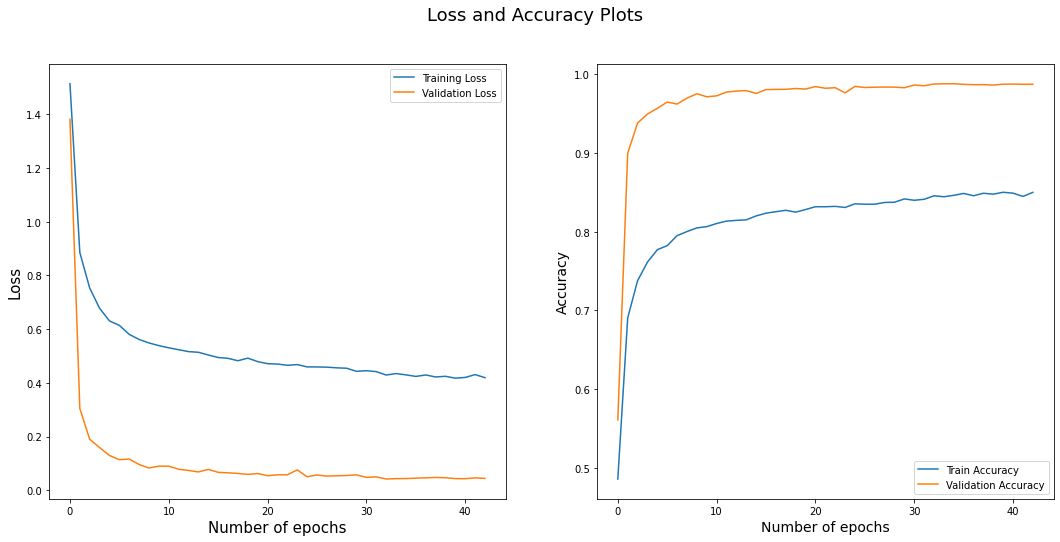

In [ ]:
#plot to visualize the loss and accuracy against number of epochs
plt.figure(figsize=(18,8))

plt.suptitle('Loss and Accuracy Plots', fontsize=18)

plt.subplot(1,2,1)
plt.plot(model_history.history['loss'], label='Training Loss')
plt.plot(model_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Number of epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)

plt.subplot(1,2,2)
plt.plot(model_history.history['accuracy'], label='Train Accuracy')
plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Number of epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.show()

In [ ]:
#plot to visualize the loss and accuracy against number of epochs
plt.figure(figsize=(18,8))

plt.suptitle('Loss and Accuracy Plots', fontsize=18)

plt.subplot(1,2,1)
plt.plot(model_history.history['loss'], label='Training Loss')
plt.plot(model_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Number of epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)

plt.subplot(1,2,2)
plt.plot(model_history.history['accuracy'], label='Train Accuracy')
plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Number of epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.show()

In [ ]:
with open('/content/drive/MyDrive/Dissertation/EfficientNetB0_MNIST/trainHistoryDict21_30', "rb") as file_pi:
    history = pickle.load(file_pi)

In [ ]:
history

## Model Evaluation

In [ ]:
model = load_model(checkpoint_filepath)

In [ ]:
model.save_weights('/content/drive/MyDrive/Dissertation/EfficientNetB0_MNIST/weights.h5')

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test_data, y_test, verbose=1)

print('Test Accuracy: ', round((test_accuracy * 100), 2), "%")

313/313 [==============================] - 13s 11ms/step - loss: 0.0431 - accuracy: 0.9869
Test Accuracy:  98.69 %


In [ ]:
test_loss, test_accuracy = model.evaluate(X_test_data, y_test, verbose=1)

print('Test Accuracy: ', round((test_accuracy * 100), 2), "%")

313/313 [==============================] - 13s 14ms/step - loss: 0.0431 - accuracy: 0.9870
Test Accuracy:  98.7 %


In [ ]:
use_units = ['GPU IDs', 'MFLOPs', 'MB', 'Million', 'MB']
profile = model_profiler(model, batch_size, use_units=use_units)
print(profile)

| Model Profile                    | Value    | Unit    |
|----------------------------------|----------|---------|
| Selected GPUs                    | ['0']    | GPU IDs |
| No. of FLOPs                     | 6.2642   | MFLOPs  |
| GPU Memory Requirement           | 142.9545 | MB      |
| Model Parameters                 | 4.0624   | Million |
| Memory Required by Model Weights | 15.4968  | MB      |


In [ ]:
use_units = ['GPU IDs', 'MFLOPs', 'MB', 'Million', 'MB']
profile = model_profiler(model, batch_size, use_units=use_units)
print(profile)

| Model Profile                    | Value    | Unit    |
|----------------------------------|----------|---------|
| Selected GPUs                    | ['0']    | GPU IDs |
| No. of FLOPs                     | 6.2642   | MFLOPs  |
| GPU Memory Requirement           | 142.9545 | MB      |
| Model Parameters                 | 4.0624   | Million |
| Memory Required by Model Weights | 15.4968  | MB      |


/usr/local/lib/python3.8/dist-packages/model_profiler/profiler.py:72: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.asarray(values).reshape(-1,1),


## Model Prediction

In [ ]:
# y_pred = model.predict(DataGenerator(X_test, mode='predict', augment=False, shuffle=False), verbose=1)
# y_pred = np.argmax(y_pred, axis=1)
# test_accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred)

# print('Test Accuracy: ', round((test_accuracy * 100), 2), "%")

## Confusion Matrix

In [ ]:
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
print(cm)

In [ ]:
#report to see which category has been predicted incorectly and which has been predicted correctly
target = ["Category {}".format(i) for i in range(n_classes)]
print(classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target))

## Visualizing the Predictions

In [ ]:
#dataframe of predictions
prediction = pd.DataFrame(y_pred)
prediction.head()

In [ ]:
#generating a random number to display a random image from the dataset along with the true and predicted label
imageId = np.random.randint(0, len(X_test))

rcParams['figure.figsize'] = 2,2

plt.imshow(X_test[imageId])

plt.axis('off')

print("True Label: " + str(subCategory.iloc[testData['fine_labels'][imageId]][0].capitalize()))
print("Predicted Label: " + str(subCategory.iloc[prediction.iloc[imageId]]).split()[2].capitalize())

In [ ]:
#16 random images to display at a time along with their true and random labels
rcParams['figure.figsize'] = 12,15

num_row = 4
num_col = 4

imageId = np.random.randint(0, len(X_test), num_row * num_col)

fig, axes = plt.subplots(num_row, num_col)

for i in range(0, num_row):
    for j in range(0, num_col):
        k = (i*num_col)+j
        axes[i,j].imshow(X_test[imageId[k]])
        axes[i,j].set_title("True: " + str(subCategory.iloc[testData['fine_labels'][imageId[k]]][0]).capitalize() 
                             + "\nPredicted: " + str(subCategory.iloc[prediction.iloc[imageId[k]]]).split()[2].capitalize(), 
                            fontsize=14)
        axes[i,j].axis('off')
        fig.suptitle("Images with True and Predicted Labels", fontsize=18) 

plt.show()

## Testing the model

In [ ]:
#function to resize the image
def resize_test_image(test_img):

    img = cv2.imread(test_img)
    #plt.imshow(img)
    img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #plt.imshow(img_RGB)
    resized_img = cv2.resize(img_RGB, (224, 224))
    #plt.imshow(resized_img)
    resized_img = resized_img / 255.
    #plt.imshow(resized_img)
    return resized_img
    
#resize_test_image('orange.jpeg')

In [ ]:
#function to get prediction for test image from the model
def predict_test_image(test_img):
    
    resized_img = resize_test_image(test_img)
    prediction = model.predict(np.array([resized_img]))
    
    return prediction

#predict_test_image('orange.jpeg')

In [ ]:
#function to get the sorted prediction
def sort_prediction_test_image(test_img):
    
    prediction = predict_test_image(test_img)
    
    index = np.arange(0,100)
    
    for i in range(100):
        for j in range(100):
            if prediction[0][index[i]] > prediction[0][index[j]]:
                temp = index[i]
                index[i] = index[j]
                index[j] = temp
                
    return index

#sort_prediction_test_image('orange.jpeg')

In [ ]:
#function to get the dataframe for top 5 predictions
def df_top5_prediction_test_image(test_img):
    
    sorted_index = sort_prediction_test_image(test_img)
    prediction = predict_test_image(test_img)
    
    subCategory_name = []
    prediction_score = []
    
    k = sorted_index[:6] 
    
    for i in range(len(k)):
        subCategory_name.append(subCategory.iloc[k[i]][0])
        prediction_score.append(round(prediction[0][k[i]], 2))
        
    df = pd.DataFrame(list(zip(subCategory_name, prediction_score)), columns=['Label', 'Probability'])  
    
    return df

#df_top5_prediction_test_image('orange.jpeg')

In [ ]:
#function to get the plot for top 5 predictions 
def plot_top5_prediction_test_image(test_img):
    
    fig, axes = plt.subplots(1, 2, figsize=(15,4))
    fig.suptitle("Prediction", fontsize=18)
    
    new_img = plt.imread(test_img)
    axes[0].imshow(new_img)
    axes[0].axis('off')
    
    data = df_top5_prediction_test_image(test_img)
    x=df_top5_prediction_test_image(test_img)['Label']
    y=df_top5_prediction_test_image(test_img)['Probability']
    
    axes[1] = sns.barplot(x=x, y=y, data=data, color="green")
    
    plt.xlabel('Label', fontsize=14)
    plt.ylabel('Probability', fontsize=14)
    
    plt.ylim(0,1.0)
    
    axes[1].grid(False)
    axes[1].spines["top"].set_visible(False)
    axes[1].spines["right"].set_visible(False)
    axes[1].spines["bottom"].set_visible(False)
    axes[1].spines["left"].set_visible(False)
    
    plt.show()

In [ ]:
plot_top5_prediction_test_image('orange.jpeg')

In [ ]:
plot_top5_prediction_test_image('Orchid.jpg')

In [ ]:
plot_top5_prediction_test_image('cat.jpeg')

In [ ]:
plot_top5_prediction_test_image('bottle.jpeg')

In [ ]:
plot_top5_prediction_test_image('lion.jpg')

In [ ]:
plot_top5_prediction_test_image('clock.jpg')

In [ ]:
plot_top5_prediction_test_image('sea.jpg')

In [ ]:
plot_top5_prediction_test_image('keyboard.jpeg')

In [ ]:
plot_top5_prediction_test_image('skunk.jpg')

In [ ]:
#saving the trained model as data file in .h5 format
model.save('cifar_efficientnetb0_model.h5')